<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/12_2_Classifica%C3%A7%C3%A3o_de_Imagens_com_Fastai_V2_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification Fastai V2



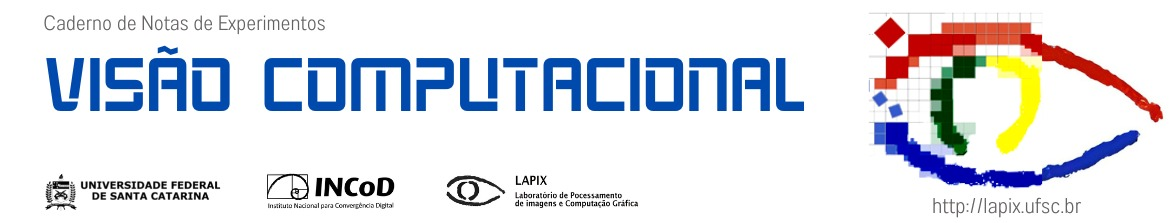

# Autores:


* Aldo von Wangenheim: aldo.vw@ufsc.br
* André Victória Matias: andre.v.matias@posgrad.ufsc.br
* Thiago Zimmermann Loureiro Chaves: thiago.zlc@grad.ufsc.br






# Para utilizar a placa de vídeo no Google Colab...

1) clique no ▾ do lado de "Conectar"

2) Ver recursos

3) Alterar o tipo de ambiente de execução

4) Acelerador de hardware: GPU

5) Execute a célula abaixo. Ela deve retornar as informações da placa de vídeo.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Thu Oct 27 16:55:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#OPCIONAL: Download Dataset Padrão

In [ ]:
!pip install gdown
!gdown 1xKxLCLAk9yQ-17SVfanJ35meDeRj2ivI
!unzip 'SplittedMendeley.zip'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0348 (8).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0040 (14).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/0- MIND0348 (1) branco2.jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/01-MIND0040 (7).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0040 (20).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/MIND0348 (7).jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset/val/Pseudohydnum gelatinosum/0- MIND0348 (1) branco.jpg  
  inflating: content/gdrive/Shareddrives/MindFunga/Spl

In [ ]:
!ls "/content/content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset"

test  train  val


## Libs setup and imports

In [ ]:
%pip install fastai==2.5.3
%pip install lapixdl==0.7.17
%pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 6.4 MB/s 
     |████████████████████████████████| 55 kB 4.7 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:38tcmalloc: large alloc 1147494400 bytes == 0x3949e000 @  0x7fb0de630615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 1.9 kB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 497 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    U

In [ ]:
import random
from pathlib import Path

import albumentations as A
import imgaug
import numpy as np
import pandas as pd
from fastai.vision.all import *
from lapixdl.evaluation.evaluate import evaluate_classification
from lapixdl.evaluation.model import Classification

# Fix seed
random.seed(81615)
imgaug.seed(81615)

## Utils

In [ ]:
class AlbumentationsTransform(Transform):
    split_idx = 0

    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)

#Montamos o drive

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Configurção dos Paths e metadata
Preenchemos os paths de acordo com a estrutura do dataset e os diretórios de output

#OPÇÃO 1: DATASET CUSTOM

In [ ]:
path_dataset = Path("Path Dataset")
path_img = (
    path_dataset / "Path Imagens"
)  # Images root folder. The images must be inside the [train|val|test]/[class] folders.
path_output = Path("Path Output")
path_models = (
    path_output / "Models"
)  # Folder where the models/weights should be saved in

path_models.mkdir(parents=True, exist_ok=True)

#OPÇÃO 2: DATASET PADRÃO

In [ ]:
path_dataset = Path("/content/content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset")
path_img = (
    path_dataset
)  # Images root folder. The images must be inside the [train|val|test]/[class] folders.
path_output = Path("/content/Output")
path_models = (
    path_output / "Models"
)  # Folder where the models/weights should be saved in

path_models.mkdir(parents=True, exist_ok=True)

#CNN Model

*   resnet18, resnet34, resnet50, resnet101, resnet152
*   squeezenet1_0, squeezenet1_1
*   densenet121, densenet169, densenet201, densenet161
*   vgg16_bn, vgg19_bn
*   alexnet

Uma lista completa de modelos disponível em: https://github.com/fastai/fastai/tree/2.5.3/fastai/vision/models

# Resnet50

ResNet é um modelo proposto em 2015 por pesquisadores da Microsoft Research que introduziu uma nova arquitetura chamada Rede Residual.

Para resolver o problema do vanishing/exploding gradient, esta arquitetura introduziu o conceito denominado Blocos Residuais. Nesta rede, usamos uma técnica chamada de skip conections. A skip connection conecta as ativações de uma camada a outras camadas, pulando algumas camadas entre elas. Isso forma um bloco residual. Resnets são feitas empilhando esses blocos residuais juntos.
A abordagem por trás dessa rede é, em vez de camadas aprenderem o mapeamento subjacente, permitimos que a rede se ajuste ao mapeamento residual

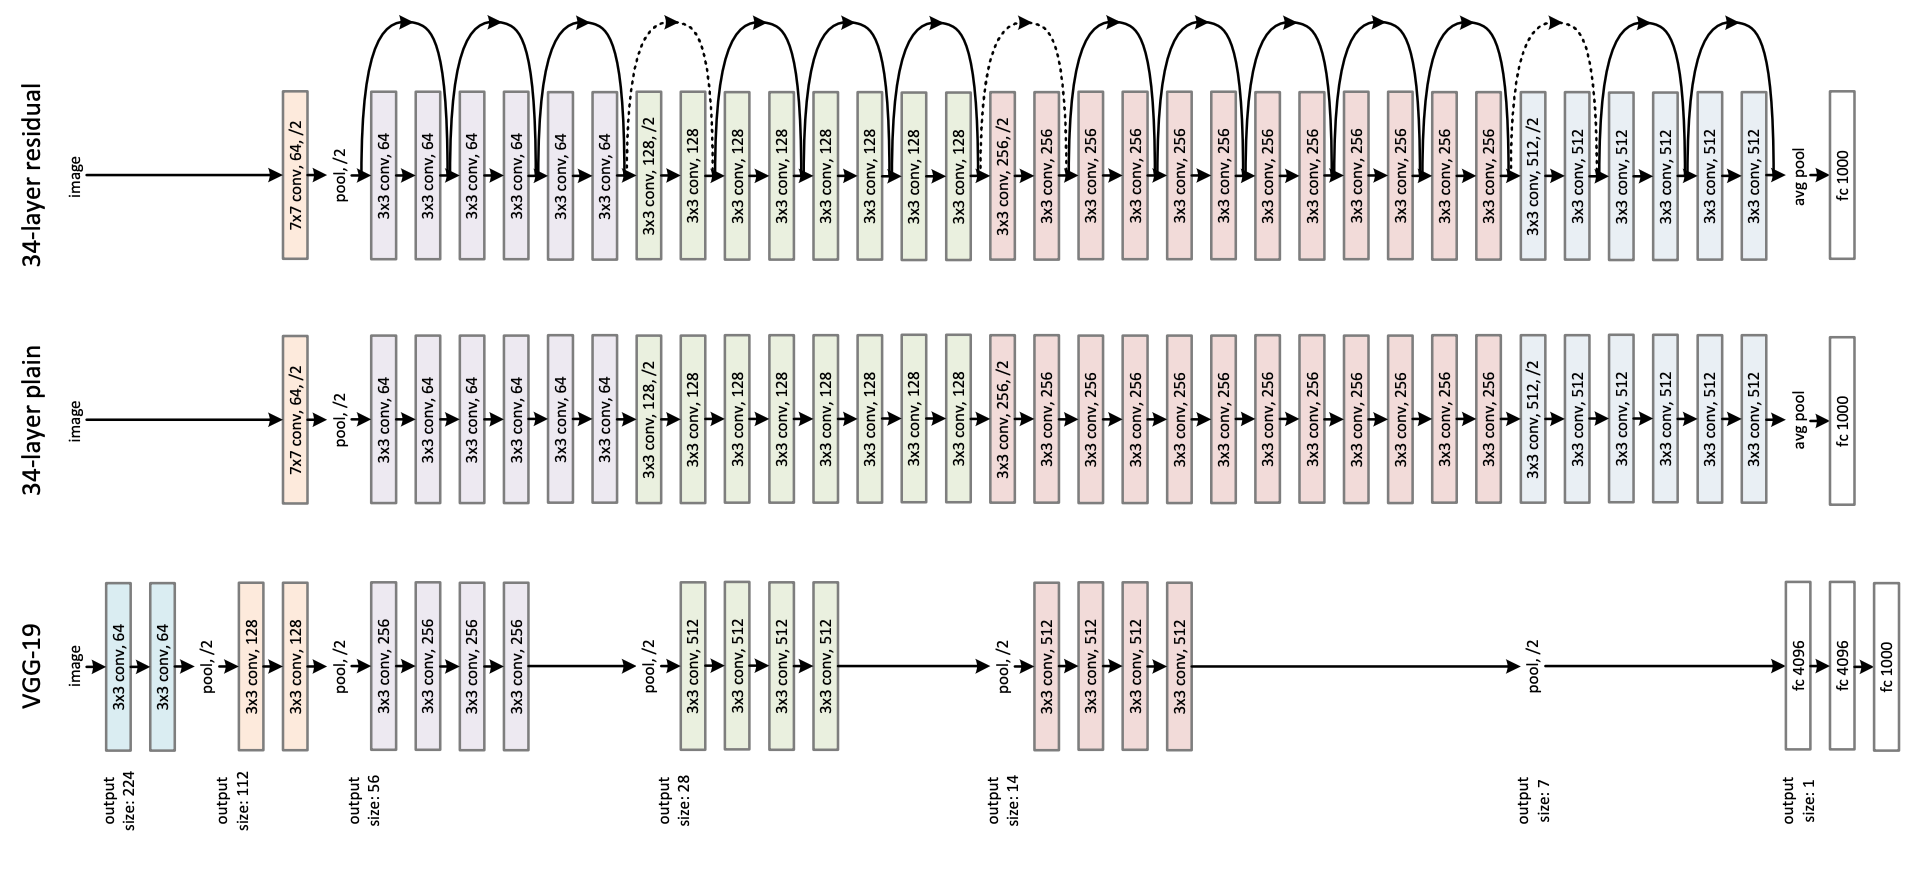



In [ ]:
from fastai.vision.models import resnet50

used_model = resnet50

## Train pipeline setup

### Pipeline

In [ ]:
augmentations = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate((-10, 10), p=0.75),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
        A.Affine(p=0.75, shear=0.2),
    ]
)

transforms = [AlbumentationsTransform(augmentations)]

In [ ]:
metrics = [
    accuracy,
    F1Score(average="macro"),
    Precision(average="macro"),
    Recall(average="macro"),
]

#Carregando o Dataloader

# Primeiro Método
##Usando Pandas

In [ ]:
# Organize images as dataframes to better control de dataloader

images_df = pd.DataFrame()
images_df["path"] = get_image_files(path_img)
images_df["is_val"] = images_df["path"].map(lambda e: "/val/" in str(e))
images_df["is_test"] = images_df["path"].map(lambda e: "/test/" in str(e))
images_df["label"] = images_df["path"].map(lambda e: e.parent.stem)
print(images_df)

In [ ]:
bs = 256  # Adjust the batch size accordingly to the GPU VRAM capacity

# Creates the dataloader
data = ImageDataLoaders.from_df(
    images_df[~images_df["is_test"]],
    fn_col="path",
    label_col="label",
    valid_col="is_val",
    path="/",
    bs=bs,
    item_tfms=transforms,
    batch_tfms=Normalize.from_stats(*imagenet_stats),
)

# Segundo Método
## Usando diretórios

Nesse formato:

Dataset
  - train
    - Especie 1
    - ...
  - valid
    - Especie 1
    - ...
  - test
    - Especie 1
    - ...

## OBS: utilizado com o dataset padrão

In [ ]:
bs = 8

data = ImageDataLoaders.from_folder(path_dataset,train='train', valid='val',test=path_dataset / "test"
                                    ,bs=bs,item_tfms=transforms,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),)

#Definindo Learner

In [ ]:
def get_learner(data, load_model=None, unfreeze:bool=False):
  """Creates and setups the learner for each step of the training approach.

  Args:
      data: Dataloader.
      load_model (str): Path to the model to be loaded.
      unfreeze (bool): Indicates if the model should be unfreezed. Defaults to False.
  """
  learn = cnn_learner(data, 
                      used_model, 
                      metrics=metrics, 
                      loss_func=CrossEntropyLossFlat()).to_fp16()
  
  learn.path = path_models
  if(load_model != None):
    learn.load(load_model)
  if(unfreeze):
    learn.unfreeze()
  return learn

# Training
## Mostrando um batch

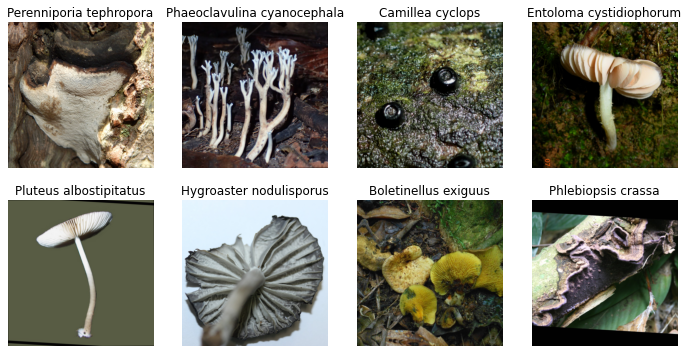

In [ ]:
data.show_batch()

# Procura a melhor learning rate

SuggestedLRs(valley=0.0020892962347716093)

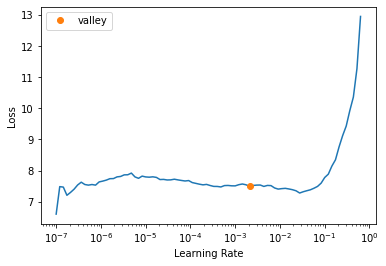

In [ ]:
# Runs the learning rate finder
get_learner(data).lr_find()

#Treinamento

## Treinamos utilizando a política de adaptação simultânea de taxa de aprendizado e momento linear da rede para superconvergência 1cycle

Abaixo um explicação retirada de nosso tutorial "How to resume an interrupted training session in fastai" disponível em: https://towardsdatascience.com/how-to-resume-an-interrupted-training-session-in-fastai-77c4f36cd3a1 

O método fit_one_cycle() empregado pelo fast.ai funciona com taxas e momentos de aprendizado variados e adaptativos, seguindo uma curva em que a taxa é aumentada e depois diminuída, enquanto o momento é tratado de forma oposta, conforme mostrado na figura abaixo.

![imagem](https://miro.medium.com/max/720/1*38YBWIKFwXN0YlNOVo_LOA.jpeg)

Se você interromper um treino na epoch #10 de, digamos, 20 epochs e depois recomeçar por mais 9 epochs, você não terá o mesmo resultado de treinar ininterruptamente por 20 epochs, porque um novo treino do zero, mesmo que você carregue os pesos da última época, empregarão uma nova taxa de aprendizado e política de impulso e passarão pelo ciclo novamente.

O que você quer é começar de onde você foi interrompido no ciclo.

![imagem](https://miro.medium.com/max/720/0*AzuB9-kayY2Abfp3.png)

### O que é fit1cycle?

Fit1cycle é uma política de superconvergência desenvolvida por Leslie N. Smith. Está disponível como a política de treinamento preferida no fast.ai. Veja abaixo os detalhes:

* https://docs.fast.ai/callbacks.one_cycle.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

Se você quiser ver mais artigos, siga este link: Papers de Leslie N. Smith. Não entraremos em detalhes nesta postagem. Existem várias postagens no Medium apresentando e discutindo a política de treinamento fit1cycle de uma maneira fácil de ler:

* Training Neural Networks upto 10x Faster by Karanbir Chahal;
* SuperConvergence with inbuilt regularization by Yogesh Gurjar;
* Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates by Aditya Gupta;
* Fast.ai Part1 v2/v3 Notes — Learning Rates — from SGDR to 1cycle and Super-Convergence by Roger Mao;
* Reproducing Leslie N. Smith’s papers using fastai by Kushajveer Singh.

Esta última postagem de Kushajveer Singh tem um notebook Jupyter muito ilustrativo que vale a pena olhar. Há também um artigo muito interessante de Nachiket Tanksale chamado Finding Good Learning Rate e The One Cycle Policy, onde as taxas de aprendizado cíclico e o momento são discutidos.

Leia o nosso tutorial para saber mais sobre treino em etapas e 1cycle. 

In [ ]:
lr = slice(8.3e-4)  # Choose accordingly to the learning rate finder results
wd = 1e-2  # Weight decay
learn = get_learner(data)
callbacks = [
    SaveModelCallback(
        monitor="f1_score", fname="best_model_stg1", with_opt=True
    ),  # Saves the best model as `fname` in `learn.path` considering the metric defined in `monitor`.
    ShowGraphCallback(),  # Shows the train/validation graph
]

# Train
learn.fit_one_cycle(10,lr_max=lr, wd=wd, cbs=callbacks)

# Mostra Resultados

In [ ]:
get_learner(data, "best_model_stg1").show_results(
    max_n=6, figsize=(20, 30)
)  # Shows example results of the trained model

# Determinamos o novo learning rate para o Finetuning

SuggestedLRs(valley=1.4454397387453355e-05)

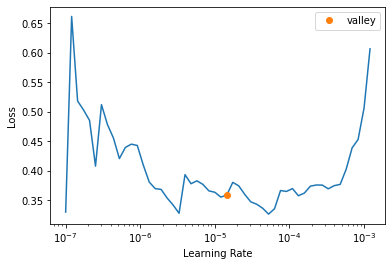

In [ ]:
# Load, unfreeze and lr finder for finetunning
get_learner(data, "best_model_stg1", True).lr_find()

#Treinamento do Finetuning

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.372790,0.337434,0.927402,0.835357,0.862739,0.829916,1:33:41
1,0.456384,0.352264,0.920605,0.820423,0.847265,0.816808,20:27
2,0.514277,0.390868,0.914736,0.809438,0.835535,0.802596,20:26
3,0.523363,0.355328,0.919679,0.817146,0.846772,0.809912,20:27
4,0.492730,0.357008,0.921841,0.818306,0.843989,0.813089,20:28
5,0.408412,0.323166,0.925857,0.821554,0.845169,0.818224,20:27
6,0.336738,0.298111,0.935434,0.841400,0.863105,0.837944,20:28
7,0.279138,0.273123,0.943157,0.855669,0.871774,0.853495,20:27
8,0.217210,0.264392,0.942848,0.857074,0.876668,0.855090,20:29


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with f1_score value: 0.8353573807933066.


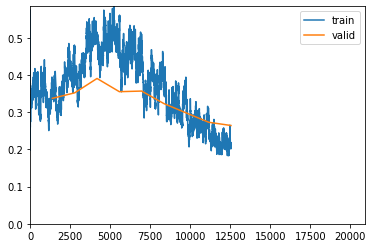

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Better model found at epoch 6 with f1_score value: 0.8414002679660957.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with f1_score value: 0.85566941166003.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 8 with f1_score value: 0.8570740685909172.


In [ ]:
lr = slice(1.44e-5, 8e-5)
wd = 1e-2
learn = get_learner(data, "best_model_stg1_MendeleyV2", True)
callbacks = [
    SaveModelCallback(monitor="f1_score", fname="best_model_stg2_MendeleyV2", with_opt=True),
    ShowGraphCallback(),
]

learn.fit_one_cycle(15, lr_max=lr, wd=wd, cbs=callbacks)

#Mostramos os resultados

In [ ]:
get_learner(data, "best_model_stg2_MendeleyV2").show_results(max_n=16, figsize=(20, 80))

## Test

Rodamos as evaluations das métricas no test set

# Primeiro Método
##Usando Pandas

In [ ]:
bs = 1
data_test = ImageDataLoaders.from_df(
    images_df[~images_df["is_bbox_only"]],
    fn_col="path",
    label_col="label",
    valid_col="is_test",
    path="/",
    bs=bs,
    batch_tfms=Normalize.from_stats(*imagenet_stats),
)

# Segundo Método
## Usando Diretórios

Nesse formato:

Dataset
  - train
    - Especie 1
    - ...
  - valid
    - Especie 1
    - ...
  - test
    - Especie 1
    - ...

In [ ]:
bs = 1
path_test = path_dataset / "test"
data_test = ImageDataLoaders.from_folder(path = path_dataset,train='test',valid='test',test = path_test, bs=bs,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),)

In [ ]:
learn = get_learner(data_test, "best_model_stg2")
ds_test = data_test.valid_ds

#Test Functions

In [ ]:
from IPython.display import Image
# Iterators to convert to the LapixDL input format

def gt_classifications(ds):
    for (img, cls) in ds:
        yield Classification(int(cls))


def pred_classifications(ds):
    for (img, cls) in ds:
        (cls_name, pred_cls, scores) = learn.predict(img)
        yield Classification(int(pred_cls), scores[int(pred_cls)])


def top5(img):
  pred_class, pred_idxs, outputs = learn.predict(img)
  top_5_conf, i = outputs.topk(5)
  itr = 0
  classes = data.classes
  for x in i:
    print("Class: %s, Probability: %.4f %%"%(classes[x.item()], top_5_conf[itr].item()*100))
    itr=itr+1
  print()

def get_prediction(img,correct):
  pred_class, pred_idxs, outputs = learn.predict(img)
  classes = data.classes
  out = list(outputs)
  index = classes.index(correct)
  prediction = out[index]
  print("%.10f %%"%(prediction.item()*100))
  print()

In [ ]:
evaluation_test = evaluate_classification(
    gt_classifications(ds_test), pred_classifications(ds_test), ds_test.vocab
)

#Plotamos a matriz de confusão

In [ ]:
evaluation_test.show_confusion_matrix()